In [2]:
import numpy as np
import random
import pandas as pd
import collections

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from keras.datasets import mnist

from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance

/home/hmenn/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# taken from hw1
def calcManhattanDistance (point1, point2):
    """
        \brief Calculate Manhattan Distance between two point
        \return Manhattan Distance
    """
    dist = 0
    for p1, p2 in zip(point1,point2):
        dist += abs(p1-p2)
    return dist

In [28]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]* x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]* x_test.shape[2])

x_data = np.concatenate((x_train, x_test))
y_data = np.concatenate((y_train, y_test))
print('Data X Shape:',x_data.shape)
print('Data Y Shape:',y_data.shape)

Data X Shape: (70000, 784)
Data Y Shape: (70000,)


(70000, 784)
(70000, 2)


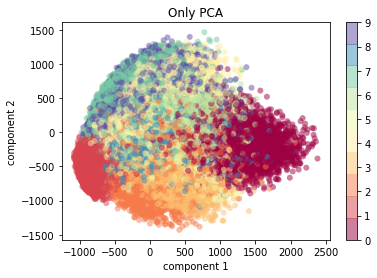

In [29]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(x_data)
print(x_data.shape)
print(projected.shape)

plt.scatter(projected[:, 0],projected[:, 1], #[0 for i in range(len(projected))]
            c=y_data, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))

plt.title("Only PCA")
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [105]:
def part2(distance_method=euclidean_distance, data_x=projected[:1000], data_y=y_data[:1000]):
    
    k = 10

    print('Data Shape:',data_x.shape,'\n')

    kf = KFold(n_splits=5)
    kFoldIndex = 1
    for trainIndex, testIndex in kf.split(data_x):
        print(' #########  KFold Step:', kFoldIndex,'  #########')

        kTrainX, kTestX = data_x[trainIndex], data_x[testIndex]
        kTrainY, kTestY = data_y[trainIndex], data_y[testIndex]

        clusterer = KMeansClusterer(k, distance_method, repeats=10)
        clusters = clusterer.cluster(kTrainX, True)

        table = np.zeros((10,10))

        for l,c in zip(kTrainY, clusters):
            table[l][c] = table[l][c] + 1

        df = pd.DataFrame(data=table, columns = ['C'+str(i) for i in range(k)])
        print('Table:\n',df,'\n')

        flattenTable = table.flatten()
        flattenTable[::-1].sort()

        orders = []
        for d in flattenTable:
            ind = np.where(table==d)
            for j in zip(*ind):
                orders.append(j)

        labelsRow = {}
        labelsCol = {}
        i = 0
        while True:
            row = orders[i][0]
            col = orders[i][1]

            if (not row in labelsRow) and (not col in labelsCol):
                labelsRow[row] = (row,col, table[row][col])
                labelsCol[col] = (row,col, table[row][col])

            if len(labelsRow) == k:
                break

            i = i + 1

        clusterLabels = {}
        for i in range(k):
            clusterLabels[labelsRow[i][1]] = labelsRow[i][0]
            print('Cluster:',labelsRow[i][1],' assigned Label:',labelsRow[i][0], ' Value:', labelsRow[i][2])
        print('\n')

        print('Converting clusters to labels on train data...')
        guess = []
        for c in clusters:
            guess.append(clusterLabels[c])

        print('Clusters were converted to labels.')
        print('Train Accuracy:', accuracy_score(guess,kTrainY))

        print('Guessing test values ...')
        testGuess = []
        for t in kTestX:
            testGuess.append(clusterLabels[clusterer.classify(t)])
        print('Test Accuracy:', accuracy_score(testGuess,kTestY),'\n')

        '''
            #plt.figure(figsize=(25, 25))
            plt.title('kMeans Cluster'+str(kFoldIndex))
            plt.subplot(plotIndex)
            plt.scatter(kTrainX[:,0],kTrainX[:, 1],
                    c=clusters, edgecolor='none', alpha=0.5,
                    cmap=plt.cm.get_cmap('Spectral', 10))
            plt.xlabel('c1')
            plt.ylabel('c2')
            plt.colorbar();
            plotIndex = plotIndex + 1
        '''
        kFoldIndex = kFoldIndex + 1    

In [106]:
%%time
part2(distance_method=euclidean_distance, data_x=projected[:1000], data_y=y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   0.0   0.0   5.0   0.0  14.0   7.0   0.0  50.0
1  76.0   0.0  13.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0
2   4.0  12.0   4.0   8.0  19.0   3.0  25.0   2.0   1.0   1.0
3   1.0  12.0   5.0  32.0  14.0   3.0   4.0   0.0   0.0   1.0
4   0.0   0.0   6.0   0.0   2.0  29.0   0.0   7.0  40.0   0.0
5   0.0   5.0  18.0  13.0  21.0   2.0  11.0   4.0   1.0   4.0
6   1.0   3.0   8.0   0.0  21.0   7.0  10.0  24.0   1.0   0.0
7   2.0   0.0  10.0   0.0   2.0  44.0   0.0   1.0  37.0   0.0
8   1.0  28.0  10.0   6.0  22.0   1.0   2.0   2.0   0.0   0.0
9   0.0   0.0  11.0   0.0   4.0  36.0   0.0   1.0  24.0   1.0 

Cluster: 9  assigned Label: 0  Value: 50.0
Cluster: 0  assigned Label: 1  Value: 76.0
Cluster: 6  assigned Label: 2  Value: 25.0
Cluster: 3  assigned Label: 3  Value: 32.0
Cluster: 8  assigned Label: 4  Value: 40.0
Cluster: 4  assigned Label: 5  

In [107]:
%%time
part2(distance_method=cosine_distance, data_x=projected[:1000], data_y=y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   1.0   1.0   1.0   4.0   0.0  55.0  14.0   0.0
1  61.0  28.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0
2   8.0   5.0  13.0  10.0   3.0  16.0   1.0  18.0   3.0   2.0
3   4.0   3.0  10.0  32.0   7.0   8.0   2.0   0.0   3.0   3.0
4   0.0   2.0   0.0   0.0  18.0   0.0  29.0   1.0   3.0  31.0
5   4.0  15.0  11.0   8.0   6.0  16.0   0.0  10.0   6.0   3.0
6   6.0   9.0   3.0   3.0   3.0   5.0   4.0  13.0  22.0   7.0
7   1.0  11.0   0.0   0.0  26.0   0.0  37.0   0.0   0.0  21.0
8  16.0   9.0  20.0  12.0   0.0   7.0   1.0   0.0   6.0   1.0
9   0.0   7.0   0.0   1.0  28.0   0.0  26.0   1.0   1.0  13.0 

Cluster: 7  assigned Label: 0  Value: 55.0
Cluster: 0  assigned Label: 1  Value: 61.0
Cluster: 5  assigned Label: 2  Value: 16.0
Cluster: 3  assigned Label: 3  Value: 32.0
Cluster: 9  assigned Label: 4  Value: 31.0
Cluster: 1  assigned Label: 5  

In [108]:
%%time
part2(distance_method=calcManhattanDistance, data_x=projected[:1000], data_y=y_data[:1000])

Data Shape: (1000, 2) 

 #########  KFold Step: 1   #########
Table:
      C0    C1    C2    C3    C4    C5    C6    C7    C8    C9
0   0.0   0.0   0.0   0.0   6.0   0.0  13.0   7.0   0.0  50.0
1  75.0  14.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0
2   4.0   5.0  12.0   5.0  16.0   3.0  29.0   3.0   1.0   1.0
3   0.0   6.0  21.0  23.0  13.0   3.0   5.0   0.0   0.0   1.0
4   0.0   6.0   0.0   0.0   2.0  29.0   0.0   7.0  40.0   0.0
5   0.0  18.0   7.0   9.0  15.0   2.0  19.0   4.0   1.0   4.0
6   1.0   8.0   3.0   0.0  21.0   6.0  11.0  24.0   1.0   0.0
7   2.0  11.0   0.0   0.0   2.0  44.0   0.0   1.0  36.0   0.0
8   1.0  12.0  30.0   3.0  19.0   1.0   4.0   2.0   0.0   0.0
9   0.0  12.0   0.0   0.0   4.0  34.0   0.0   1.0  25.0   1.0 

Cluster: 9  assigned Label: 0  Value: 50.0
Cluster: 0  assigned Label: 1  Value: 75.0
Cluster: 6  assigned Label: 2  Value: 29.0
Cluster: 3  assigned Label: 3  Value: 23.0
Cluster: 8  assigned Label: 4  Value: 40.0
Cluster: 1  assigned Label: 5  

In [109]:
import gc
gc.collect()

190